In [16]:
# Import gofer_auth.py - han~dles authentication (token will remain for a limited time)
import gofer_auth

In [17]:
# Imports for first test
import requests
import time
import sys
from urllib.parse import urlencode
from gofer_auth import AcquireNewAccessTokenInteractiveFlow as get_token
API_LOCATION = "https://api.gofer.oasys-software.com"

import matplotlib.pyplot as plt
import math

In [18]:
# Get token, define high level GET, PUT and DEF functions for later use
auth_token = get_token() # using function from gofer_auth

def get(route):
    url = f"{API_LOCATION}/{route}"
    headers = {'authorization': 'Bearer ' + auth_token}
    res = requests.get(url, headers=headers)
    if res.status_code == 200:
        return res.json()
    else:
        return res.text

def put(route,  data = {}):
    url = f"{API_LOCATION}/{route}"
    headers = {'Authorization': 'Bearer ' + auth_token, "Content-Type": "application/json" }
    res = requests.put(url, headers=headers, json=data)
    return res

def post(route,  data = {}):
    url = f"{API_LOCATION}/{route}"
    headers = {'Authorization': 'Bearer ' + auth_token, "Content-Type": "application/json" }
    res = requests.post(url, headers=headers, json=data).json()
    return res

In [26]:
# Function to get a list of my models, use to find ID of target model
def get_model_IDs():
    try:
        model_list = get("v1/models/")
        assert len(model_list) > 0
    except AssertionError:
        return 'No models found'
    else:
        return model_list

my_model_list = get_model_IDs() 
if my_model_list == 'No models found':
    print(my_model_list)
else:
    print(*my_model_list, sep = '\n\n')

{

"

p

a

t

h

"

:

"

/

v

1

/

m

o

d

e

l

s

/

"

,

"

s

t

a

t

u

s

C

o

d

e

"

:

4

0

1

,

"

m

e

s

s

a

g

e

"

:

{

"

s

t

a

t

u

s

C

o

d

e

"

:

4

0

1

,

"

m

e

s

s

a

g

e

"

:

"

U

n

a

u

t

h

o

r

i

z

e

d

"

}

}


In [ ]:
# Copy the model ID from above
orig_ID = "<ENTER MODEL ID>"

In [ ]:
# Duplicate the model. Only the copy will be modified
orig_model = get("v1/models/" + orig_ID) # Get the target model
mod_model = post("v1/models", orig_model) # Upload it to create a copy with new ID

In [ ]:
# Print the list of models again
new_model_list = get_model_IDs()
if new_model_list == 'No models found':
    print(new_model_list)
else:
    print(*new_model_list, sep = '\n\n')

In [ ]:
# Copy the new model ID from above
mod_ID = "<ENTER MODEL ID>"

In [ ]:
# Function to create a path to model's analysis results
def getAnalysisPath(modelID):
    return "v1/models/" + modelID + "/analysis"

In [ ]:
# Function to get analysis results
def waitForAnalysis(modelID):
    # Send for analysis
    model_status = post(getAnalysisPath(modelID))
    
    # Poll the Analysis Status until it succeeds
    allDone = False
    failed = False
    while not allDone and not failed:
        time.sleep(2)
        allDone = True
        model_status = get(getAnalysisPath(modelID))
        for _, status in enumerate(model_status):
            status = status['analysisStatus']
            if status in [1,2,6]:
                allDone = False
            if status in [4,5,8]:
                failed = True
    return model_status 

orig_analysis = waitForAnalysis(orig_ID)
mod_analysis = waitForAnalysis(mod_ID)

In [ ]:
# Get the number of stages in the models
num_stages = len(orig_analysis)
print(num_stages)

In [ ]:
# Get nodes for the last stage in the original model
last_stage_orig_ID = orig_analysis[4]['id'] # last stage is at index 4
last_results_orig = get("v1/models/" + orig_ID + "/stages/" + last_stage_orig_ID + "/results?type=default")['nodes'] # get the nodes
print(last_results_orig[0]) # print for the 0th node

In [ ]:
# Get a list of all structures in the model
orig_structures = get("v1/models/" + orig_ID)['structures']
print(*orig_structures, sep = '\n\n')

In [ ]:
# Copy ID of the structure you want to use from above
str_ID = "<ENTER STRUCTURE ID>"

In [ ]:
# Function for getting index of an element in a list
def get_index(modelID, elemID, list_name):
    l = get("v1/models/" + modelID)[list_name] # get the list from model
    for e in l: # find the element
        if e['id'] == elemID:
            index = l.index(e) # get the index
            return index

In [ ]:
# Get and print the value for the structure - now it is the same in both models
str_index = get_index(mod_ID, str_ID, 'structures') # get index of the structure

str_youngsModulusE_before = orig_structures[str_index]['youngsModulusE'] # get the value
print(str_youngsModulusE_before)

In [ ]:
# Change the value of youngsModulusE in the structure from 40MPa to 20MPa in duplicate model
cmd = {"jsonPath" : '$.structures.' + str(str_index) + '.youngsModulusE', "value" : 20000} # create input for PUT function
update_param = put("v1/models/" + mod_ID, cmd) # update the parameter value

if update_param.status_code == 200:
    print('The update was successful')
else:
    print('Status code %s' %update_param.status_code)

In [ ]:
# Verify that the value of youngsModulusE changed in the duplicate model
mod_structures = get("v1/models/" + mod_ID)['structures'] # get the list of updated structures

str_youngsModulusE_after = mod_structures[str_index]['youngsModulusE'] # get the value
print(str_youngsModulusE_after)

In [ ]:
# Analyse the model again with the new value
mod_analysis = waitForAnalysis(mod_ID)

In [ ]:
# Get nodes for the last stage in the modified model
last_stage_mod_ID = mod_analysis[4]['id'] # last stage is at index 4
last_results_mod = get("v1/models/" + mod_ID + "/stages/" + last_stage_mod_ID + "/results?type=default")['nodes'] # get the nodes
print(last_results_mod[0]) #print for the 0th node

In [ ]:
# Plot bending moment for structural element nodes at the last stage of both models

# For original model:
orig_y_list = [] # new list for y positions (for plotting)
orig_BM_list = [] # new list for bending moment values (for plotting)

for i in last_results_orig: # loop through all nodes at the final stage
    if i['bendingMoment'] != None: # consider only the nodes of structural elements, i.e. with non-None bendingMoment values
        y = i['y'] # get the y position of the node
        orig_y_list.append(y) # add value to the y list
        BM = i['bendingMoment'] # get the bending moment value
        orig_BM_list.append(BM) # add it to the bending moment list
        BMM = max(BM, key = abs)

# Repeat for modified model:
mod_y_list = []
mod_BM_list = []

for i in last_results_mod:
    if i['bendingMoment'] != None: 
        y = i['y'] 
        mod_y_list.append(y)
        BM = i['bendingMoment']
        mod_BM_list.append(BM)

# Plotting:       
plt.scatter(orig_BM_list, orig_y_list, color = '#82064F', label = 'Original') # plot bending moment for original model
plt.scatter(mod_BM_list, mod_y_list, color = '#0095B6', label = 'Modified') # plot bending moment for modified model

plt.legend() # add the legend
plt.xlabel('BM (kN*m)') # label x-axis
plt.ylabel('Y position (m)') # label y-axis
plt.show() # show the graph

In [30]:
import pandas as pd

# define calculation of concrete volume
def calculate_concrete_volume(diameter, length):
    pi = 3.1415
    concrete_volume = length * (diameter ** 2) * pi / 4
    return concrete_volume

# define how to get the steel diameter in reality
def round_number(steel_diameter, steel_list):
    steel_diameter_fixed = round(steel_diameter)

    if steel_diameter_fixed in steel_list:
        return steel_diameter_fixed

    steel_fixed = min(steel_list, key=lambda x: abs(x - steel_diameter_fixed))
    return steel_fixed

# define calculation of steel volume
def calculate_steel_volume(bending_moment, diameter, length, yield_strength_steel, steel_list):
    steel_area = bending_moment * 1000000 / (0.87 * diameter * 1000 * yield_strength_steel)
    steel_diameter = pow(steel_area * 4 / (6 * 3.1415), 0.5)
    steel_diameter_fixed = round_number(steel_diameter, steel_list)
    steel_area_fixed = 6 * (steel_diameter_fixed ** 2) * 3.1415 / (4 * 1000000)
    steel_volume = steel_area_fixed * length
    return steel_volume

#input data from outside, example in excel here
df = pd.read_excel('calculation.xlsx', sheet_name='Sheet2')
bending_moment = df['A'].tolist()
diameter = df['B'].tolist()

length = 26
yield_strength_steel = 500 / 1.15
steel_list = [8, 10, 12, 16, 20, 25, 32, 40, 50]

concrete_volume = []
for data in diameter:   
    
    result = calculate_concrete_volume(diameter, length)
    concrete_volume.append (result)

steel_volume = []
for data in bending_moment:
    result = calculate_steel_volume(bending_moment, diameter, length, yield_strength_steel, steel_list)
    steel_volume.append (result)
        
#create dataframe for the result
output_df = pd.DataFrame({'concrete volume': concrete_volume, 'steel volume': steel_volume})

        


TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

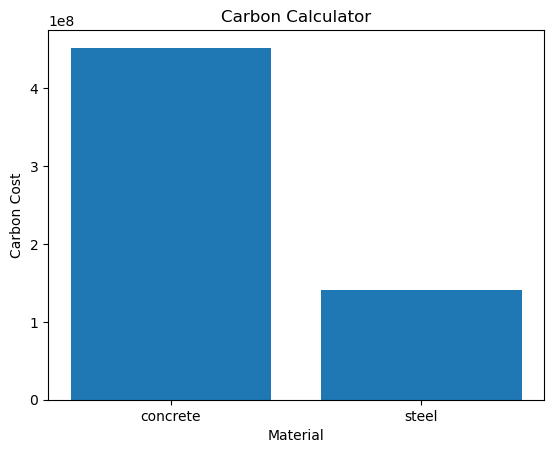

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

#define carbon emission and cost
def calculate_concrete_carbon_cost(concrete_volume, carbon_factor, cost_factor):
    concrete_density = 2400 # kg per cubic
    carbon_emission = concrete_volume * concrete_density * carbon_factor
    cost = concrete_volume * concrete_density * cost_factor
    concrete_carbon_cost = carbon_emission + cost
    return concrete_carbon_cost

def calculate_steel_carbon_cost(steel_volume, carbon_factor, cost_factor):
    steel_density = 1500 # kg per cubic
    carbon_emission = steel_volume * steel_density * carbon_factor
    cost = steel_volume * steel_density * cost_factor
    steel_carbon_cost = carbon_emission + cost
    return steel_carbon_cost

# Carbon factors for different materials and energy (in kilograms of CO2 per unit)
carbon_factors = {
    'CEM I': 860,
    'Aggregate': 4,
    'sand': 6,
    'water': 0.149,
    'bentonite': 539,
    'steel_rebars': 1383.31,
}

# Cost factors for different materials (in pounds of cost per unit)
cost_factors = {
    'CEM I': 200,
    'Aggregate': 10,
    'sand': 10,
    'water': 10,
    'bentonite': 150,
    'steel_rebars': 500,
}
#input data from design solution
concrete_volume = 

# example concrete and steel volumes
concrete_volume = 100  # example value, replace with the actual concrete volume
steel_volume = 50  # example value, replace with the actual steel volume

total_carbon_cost = 0.0
concrete_carbon_cost = 0.0
steel_carbon_cost = 0.0

# Calculate carbon cost for each material
for material, carbon_factor in carbon_factors.items():
    cost_factor = cost_factors.get(material, 0)

    concrete_carbon_cost = calculate_concrete_carbon_cost(concrete_volume, carbon_factor, cost_factor)
    steel_carbon_cost = calculate_steel_carbon_cost(steel_volume, carbon_factor, cost_factor)
    total_carbon_cost += (concrete_carbon_cost + steel_carbon_cost)

# Create DataFrame for visualization
carbon = {
    'material': ['concrete', 'steel'],
    'carbon': [concrete_carbon_cost, steel_carbon_cost]
}
df = pd.DataFrame(carbon)

# Plot the results
plt.xlabel('Material')
plt.ylabel('Carbon Cost')
plt.title('Carbon Calculator')
plt.bar(df['material'], df['carbon'])
plt.show()






In [ ]:
from platypus import NSGAII, Problem, Real

def carbon_serveciability(concrete_volume,steel_volume):
    x = vars[0]
    y = vars[1]
    return [-2*x + y, 2*x + y], [-x + y - 1, x + y - 7]

problem = Problem(2, 2, 2)